# Operations on word vectors

In this we will do:
- Load pre-trained word vectors, and measure similarity cosine similarity.
- Use word embeddings to solve word analogy problems such as Man is to Woman as King is to ____.
- Modify word embeddings to reduce their gender bias.

In [1]:
import numpy
from w2v_utils import *

Load the word vectors

- will use 50-dimensional GloVe vectors to represent words.

In [2]:
words, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

## 1. Consine similarity

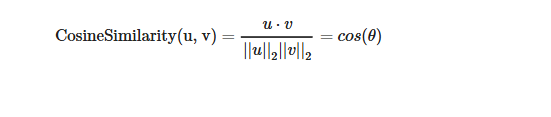

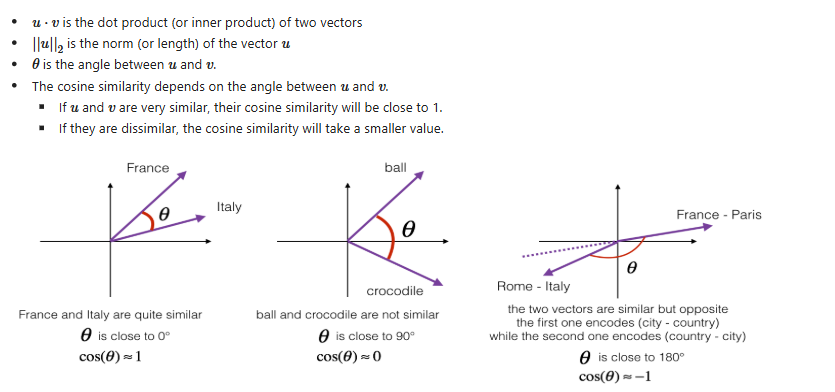

In [3]:
def cosine_similarity(u, v):
    distance = 0.0
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity

In [4]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.2743924626137942
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174201


## 2. Word analogy task

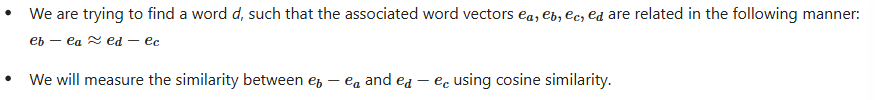

In [5]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]

    words = word_to_vec_map.keys()
    max_cosine_sim = -100
    best_word = None

    input_words_set = set([word_a, word_b, word_c]) # in set for faster searching

    for w in words: # over whole vector set
        if w in input_words_set: # to avoid best_word being one of the inputs
            continue

        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)

        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w

    return best_word



In [6]:
# let's test this with some triads
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print('{} -> {} :: {} -> {}'.format(*triad, complete_analogy(*triad, word_to_vec_map)))


italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> larger


### Remember:

- Cosine similarity is a good way to compare the similarity between pairs of word vectors.
- Note that L2 (Euclidean) distance also works.
- For NLP applications, using a pre-trained set of word vectors is often a good way to get started.

## 3. Debiasing word vectors

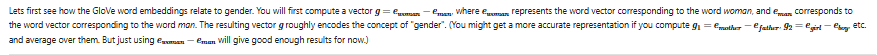

In [7]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


In [8]:
print ('List of names and their similarities with constructed vector:')

# names of boys and girls
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print(w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.315597935396073
sophie 0.31868789859418784
ronaldo -0.31244796850329437
priya 0.17632041839009402
rahul -0.16915471039231716
danielle 0.24393299216283895
reza -0.07930429672199553
katy 0.2831068659572615
yasmin 0.23313857767928758


as you can see, female first names tend to have a positive cosine similarity with our constructed vector `g`, while male first names tend to have a negative cosine similarity. This is not surprising, and the result seems acceptable.


In [10]:
# some other words
print('Other words and their similarities')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior', 'doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print(w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities
lipstick 0.2769191625638267
guns -0.1888485567898898
science -0.06082906540929701
arts 0.008189312385880337
literature 0.06472504433459932
warrior -0.20920164641125288
doctor 0.11895289410935041
tree -0.07089399175478091
receptionist 0.33077941750593737
technology -0.13193732447554302
fashion 0.03563894625772699
teacher 0.17920923431825664
engineer -0.0803928049452407
pilot 0.0010764498991916937
computer -0.10330358873850498
singer 0.1850051813649629


will reduce the bias of these vectors, using an algorithm due to [Paper to read about gender biased terms, for more info](https://arxiv.org/pdf/1607.06520)

### 3.1 Neutralize bias for non-gender specific words

- In a 50-dimensional word embedding, one dimension can represent a bias-direction $g$ and the remaining 49 dimensions, $g^\perp$, are orthogonal to it. The neutralization step removes the component of a word vector (e.g., *receptionist*) along $g$, producing a debiased vector (*edebaised receptionist*).


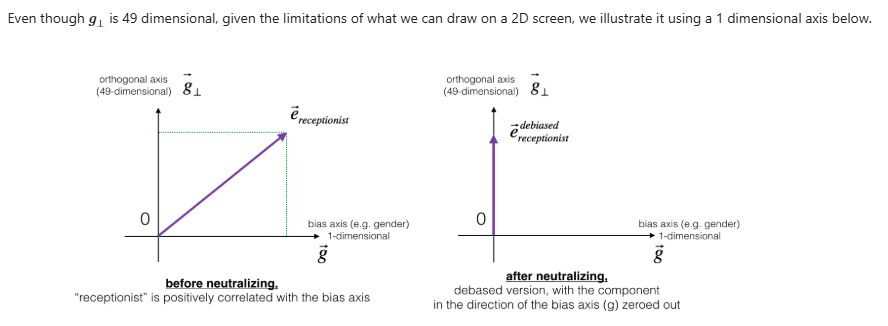

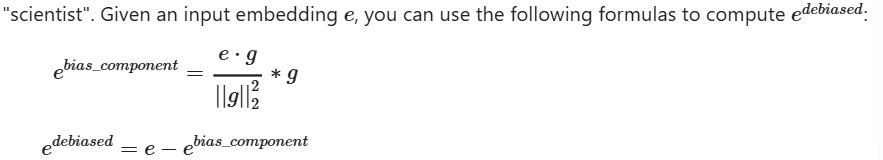

In [13]:
def neutralize(word, g, word_to_vec_map):

    e = word_to_vec_map[word]
    # computes the Euclidean (L2) norm of g
    e_biascomponent = np.dot(e, g) / ((np.linalg.norm(g)) ** 2) * g
    e_debiased = e - e_biascomponent

    return e_debiased

In [14]:
e = 'receptionist'
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))

cosine similarity between receptionist and g, before neutralizing:  0.33077941750593737
cosine similarity between receptionist and g, after neutralizing:  -2.099120994400013e-17


second result is essentially 0, up to numerical rounding (on the order of $10^{-17}$).

### 3.2 Equalizing algorithm for gender-specific words

Equalization is applied to pairs of words that you might want to have differ only through the gender property. As a concrete example, suppose that "actress" is closer to "babysit" than "actor." By applying neutralizing to "babysit" we can reduce the gender-stereotype associated with babysitting. But this still does not guarantee that "actor" and "actress" are equidistant from "babysit." The equalization algorithm takes care of this.

The key idea behind equalization is to make sure that a particular pair of words are equi-distant from the 49-dimensional $g^\perp$. The equalization step also ensures that the two equalized steps are now the same distance from $e^{\text{debiased receptionist}}$, or from any other work that has been neutralized. In pictures, this is how equalization works:



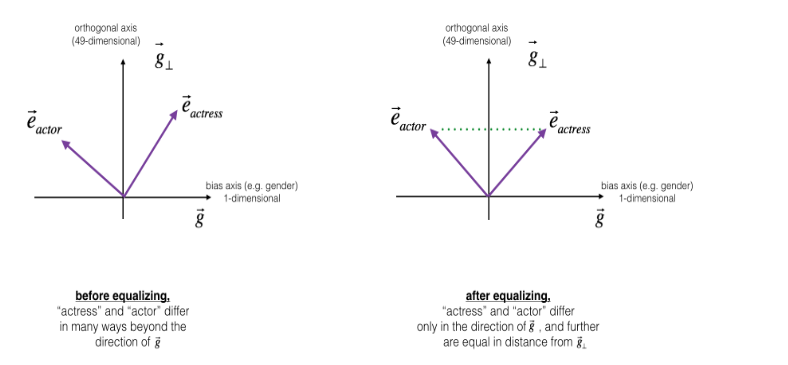

key equations:

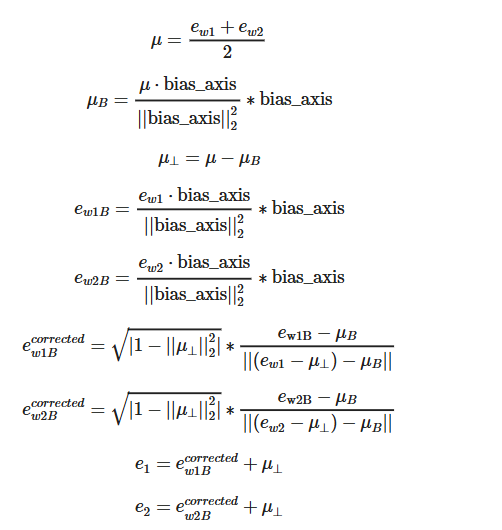

In [16]:
def equalize(pair, bias_axis, word_to_vec_map):

    w1, w2 = pair[0], pair[1]
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]

    mu = (e_w1 + e_w2) / 2 # mean of the two

    # projections of mu over the bias axis and the orthogonal axis
    mu_B = (np.dot(mu, bias_axis) / np.linalg.norm(bias_axis) ** 2) * bias_axis
    mu_orth = mu - mu_B

    e_w1B = (np.dot(e_w1, bias_axis) / np.linalg.norm(bias_axis) ** 2) * bias_axis
    e_w2B = (np.dot(e_w2, bias_axis) / np.linalg.norm(bias_axis) ** 2) * bias_axis

    # adjusting the bias of part of e_w1B and e_w2B using above equations
    corrected_e_w1B = np.sqrt(np.abs(1 - np.linalg.norm(mu_orth) ** 2)) * ((e_w1B - mu_B) / np.abs((e_w1 - mu_orth) - mu_B))
    corrected_e_w2B = np.sqrt(np.abs(1 - np.linalg.norm(mu_orth) ** 2)) * ((e_w2B - mu_B) / np.abs((e_w2 - mu_orth) - mu_B))

    # debiasing  by e1 and e2 to the sum of their corrected projections
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth

    return e1, e2


In [17]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.11711095765336832
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.7165727525843935
cosine_similarity(e2, gender) =  0.7396596474928909


## 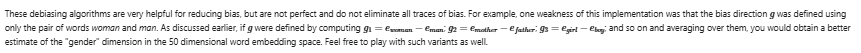

# Finish.